<a href="https://colab.research.google.com/github/641-boop/liusiyide/blob/main/BBO_Funcv3_1_NotebookvDev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

just checking

<h1> Black Box Optimizer v3.1: </h1>
+ Log Scale Random Number Through Manual Input<br>           
+ Multiple Stocks<br>
+ Multiple Alternatives<br>
+ Echo Machine File Output<br>
+ Table2Speech File Output<br>
+ Visualising Results as BoxPlot<br>
+ Visualising Results for each Metabolite<br>
+ Visualising Concentrations for each Day<br>
+ Find K Most Informative combinations<br>
+ Find Metabolite's Importance<br>
+ Find NonLinear Interactions<br>



In [20]:
import pandas as pd
import numpy as np
import os
from xgboost import XGBRegressor
import time
from sklearn.model_selection import RandomizedSearchCV
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
from collections.abc import Iterable
import math
import random
from scipy.stats import spearmanr, pearsonr

pd.options.mode.chained_assignment = None  # default='warn'
!wget https://raw.githubusercontent.com/myprogrammerpersonality/BlackBoxOptimizer/master/Functions_Final_v3_1.py

from Functions_Final_v3_1 import *

--2025-06-18 09:16:40--  https://raw.githubusercontent.com/myprogrammerpersonality/BlackBoxOptimizer/master/Functions_Final_v3_1.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22100 (22K) [text/plain]
Saving to: ‘Functions_Final_v3_1.py’

Functions_Final_v3_ 100%[===================>]  21.58K  --.-KB/s    in 0s      

2025-06-18 09:16:40 (129 MB/s) - ‘Functions_Final_v3_1.py’ saved [22100/22100]



This notebook includes all data processing, bayesian optimization and results visualisation

# User Inputs

<p1><h2> When to use this part:</h2>
* every time before using BBO you should fill this part based on your project</p1>
<p1><h2> How to use this part:</h2>
* User should upload all available Results file (i.e. Results_1.csv to Results_n.csv) to runtime from Files/UploadFile
* now there is an example, change it to your project</p1>

In [21]:
# General Parameters:
m = 20      # number_of_combination_each_round
minimum_drop_size_nanoliter = 100
final_reaction_volume_nanoliter = 20000
maximum_volume_of_model_output = 9300 # (e.g. volume except fixed parts - 100 nl avoid 0 water)
fixed_parts = {'Lysate':0.33, 'EnergyBuffer':0.175, 'IPTG-Water':0.025} # 0.33 means 33% of total volume will be Lysate, 15% energy mix(except variable one), 2.5% IPTG
days_total = 10 # how many days you want to continue # set it at your max prediction

# Model Parameters:
RandomCV = True
n_iter = 200
ensemble_len = 20
exploration = {1: 1.41, 2: 1.41, 3: 1.41,
               4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0,
               8: 0.5, 9: 0.5, 9: 0.5, 10: 0.5}
days_range = [m for i in range(days_total)]

In [22]:
# Part 1: choose grid for our metabolite conc and define stock concentration

# it is important to define all value for function to be able to get conc that is appropriate to your minimum drop size
# each metabolite min, max and stock must be in same units

# concentrations_limits :
# *** metabolite name must not includes "_" ***

concentrations_limits = {
 'PEG':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], 'Conc_Stock':50.0, 'Alternatives':None},
 'DTT':{'Conc_Min':0.0, 'Conc_Max':4.0, 'Conc_Values':None, 'Conc_Stock':100.0, 'Alternatives':None},
 'Spermidine':{'Conc_Min':0.2, 'Conc_Max':2.0, 'Conc_Values':None, 'Conc_Stock':40.0, 'Alternatives':None},
 'T7Pol':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[0.0078, 0.0156, 0.0273, 0.039, 0.0507, 0.0624, 0.0702, 0.078], 'Conc_Stock':0.78, 'Alternatives':None},
 't-RNA':{'Conc_Min':0.04, 'Conc_Max':0.04, 'Conc_Values':None, 'Conc_Stock':8.0, 'Alternatives':None},
 'AminoAcids':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[0.75], 'Conc_Stock':6.0, 'Alternatives':None},
 'TF-plasmid':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[5.0,10.0,20.0,40.0,60.0,80.0,100.0], 'Conc_Stock':2000.0, 'Alternatives':None},
 'Circuit-plasmid':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[10.0], 'Conc_Stock':1000.0, 'Alternatives':['pTAC','pTHS','pDC','pSTAR']}}

In [23]:
# Check Possible Concentrations
data_lists = {}
num = 0
for key, value in concentrations_limits.items():
    print('Possible Conc For :',key)
    if not value['Conc_Values']:
        print('Your Min, Max :', "({}, {})".format(value['Conc_Min'], value['Conc_Max']))
    concs, vols = allowed_output(value, reaction_vol_nl = final_reaction_volume_nanoliter, drop_size_nl = minimum_drop_size_nanoliter, verbose=0)
    print(concs)
    print(vols)
    data_lists[num] = vols
    num += 1
    print()

percent , pool_size = percentage_possible(data_lists, threshold = maximum_volume_of_model_output)
print(percent, f'% of {pool_size} possible combination are executable!')
if pool_size > 10000000: pool_size = 10000000

Possible Conc For : PEG
[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
[400.0, 600.0, 800.0, 1000.0, 1200.0, 1400.0, 1600.0, 1800.0, 2000.0]

Possible Conc For : DTT
Your Min, Max : (0.0, 4.0)
[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
[0, 100, 200, 300, 400, 500, 600, 700, 800]

Possible Conc For : Spermidine
Your Min, Max : (0.2, 2.0)
[0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

Possible Conc For : T7Pol
[0.0078, 0.0156, 0.0273, 0.039, 0.0507, 0.0624, 0.0702, 0.078]
[200.0, 400.0, 700.0, 1000.0, 1300.0, 1600.0, 1800.0, 2000.0]

Possible Conc For : t-RNA
Your Min, Max : (0.04, 0.04)
[0.04]
[100]

Possible Conc For : AminoAcids
[0.75]
[2500.0]

Possible Conc For : TF-plasmid
[5.0, 10.0, 20.0, 40.0, 60.0, 80.0, 100.0]
[50.0, 100.0, 200.0, 400.0, 600.0, 800.0, 1000.0]

Possible Conc For : Circuit-plasmid
[10.0]
[200.0]

99.98015873015873 % of 45360 possible combination are executable!


In [24]:
# add reference and negative control
# leave it empty if you dont need
# you can add more desired combination to this dictionary
# *** conc in these dic must be compatible with minimum drop size ***

specials = {}

# Day 1 (in absence of Day_0)

<p1><h2> When to use this part:</h2>
* after filling "User Input" if you have no pre existing data (Day_0.csv)
<p1><h2> How to use this part:</h2>
* just run all cells!


In [25]:
# make random combinations
Concentrations_1 = random_combination_generator(concentrations_limits, number_of_combination = m,
                                                reaction_vol_nl=final_reaction_volume_nanoliter,
                                                max_nl=maximum_volume_of_model_output, drop_size_nl=minimum_drop_size_nanoliter, return_df=True)

# add control, reference and other desired combinations
df_specials = [pd.DataFrame(i) for i in specials.values()]
Concentrations_1 = pd.concat([Concentrations_1, *df_specials]).reset_index(drop=True)

Concentrations_1

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,Circuit-plasmid,Circuit-plasmid_pTAC,Circuit-plasmid_pTHS,Circuit-plasmid_pDC,Circuit-plasmid_pSTAR
0,5.0,3.0,2.0,0.0390,0.04,0.75,20.0,10.0,1.0,0.0,0.0,0.0
1,4.5,4.0,0.6,0.0156,0.04,0.75,10.0,10.0,1.0,0.0,0.0,0.0
2,5.0,2.5,1.4,0.0507,0.04,0.75,5.0,10.0,0.0,0.0,0.0,1.0
3,1.0,0.0,1.6,0.0702,0.04,0.75,40.0,10.0,0.0,1.0,0.0,0.0
4,5.0,2.5,1.6,0.0624,0.04,0.75,10.0,10.0,0.0,0.0,1.0,0.0
5,3.0,0.0,0.8,0.0156,0.04,0.75,10.0,10.0,0.0,0.0,0.0,1.0
6,1.0,0.5,1.4,0.0156,0.04,0.75,20.0,10.0,0.0,1.0,0.0,0.0
7,4.5,2.0,1.4,0.0702,0.04,0.75,60.0,10.0,1.0,0.0,0.0,0.0
8,5.0,3.5,0.6,0.0156,0.04,0.75,60.0,10.0,0.0,1.0,0.0,0.0
9,1.5,3.5,0.6,0.0507,0.04,0.75,20.0,10.0,1.0,0.0,0.0,0.0


In [26]:
!mkdir -p Day_1
Concentrations_1.to_csv('Day_1/Concentrations_1.csv', index=False)

In [27]:
# concentration_to_volume
Volumes_1 = concentration_to_volume(Concentrations_1, concentrations_limits, reaction_mixture_vol_nl=final_reaction_volume_nanoliter,
                                    fixed_parts=fixed_parts)
Volumes_1.to_csv('Day_1/Volumes_1.csv', index=False)
Volumes_1

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,Circuit-plasmid,Circuit-plasmid_Type,Lysate,EnergyBuffer,IPTG-Water,water
0,2000.0,600.0,1000.0,1000.0,100.0,2500.0,200.0,200.0,pTAC,6600.0,3500.0,500.0,1800.0
1,1800.0,800.0,300.0,400.0,100.0,2500.0,100.0,200.0,pTAC,6600.0,3500.0,500.0,3200.0
2,2000.0,500.0,700.0,1300.0,100.0,2500.0,50.0,200.0,pSTAR,6600.0,3500.0,500.0,2050.0
3,400.0,0.0,800.0,1800.0,100.0,2500.0,400.0,200.0,pTHS,6600.0,3500.0,500.0,3200.0
4,2000.0,500.0,800.0,1600.0,100.0,2500.0,100.0,200.0,pDC,6600.0,3500.0,500.0,1600.0
5,1200.0,0.0,400.0,400.0,100.0,2500.0,100.0,200.0,pSTAR,6600.0,3500.0,500.0,4500.0
6,400.0,100.0,700.0,400.0,100.0,2500.0,200.0,200.0,pTHS,6600.0,3500.0,500.0,4800.0
7,1800.0,400.0,700.0,1800.0,100.0,2500.0,600.0,200.0,pTAC,6600.0,3500.0,500.0,1300.0
8,2000.0,700.0,300.0,400.0,100.0,2500.0,600.0,200.0,pTHS,6600.0,3500.0,500.0,2600.0
9,600.0,700.0,300.0,1300.0,100.0,2500.0,200.0,200.0,pTAC,6600.0,3500.0,500.0,3500.0


# Other Days

<p1><h2> When to use this part:</h2>
* whene you have either pre existing data (Results_0.csv) or Results_1 to Results_n
<p1><h2> How to use this part:</h2>
* just run all cells!

In [28]:
day = day_finder('Results') - 1
start_day = (1, 0)[os.path.isfile('Results_0.csv')]
print(start_day, day)

0 30


In [29]:
import pandas as pd
import numpy as np
import os

# 创建目录用于保存模拟数据
os.makedirs("simulated_results", exist_ok=True)

# 你模型需要的字段（除了 'yield' 以外）
columns = [
    'PEG', 'DTT', 'Spermidine', 'T7Pol', 't-RNA', 'AminoAcids',
    'TF-plasmid', 'Circuit-plasmid', 'Circuit-plasmid_pTAC',
    'Circuit-plasmid_pTHS', 'Circuit-plasmid_pDC', 'Circuit-plasmid_pSTAR'
]

# 每个文件生成 50 条记录
num_rows = 50
num_days = 31  # Results_0.csv 到 Results_30.csv

for day in range(num_days):
    df = pd.DataFrame(np.random.rand(num_rows, len(columns)), columns=columns)
    df['yield'] = np.random.rand(num_rows) * 100  # 假设产量是 0~100 之间
    df.to_csv(f"Results_{day}.csv", index=False)

print("✅ 成功生成 Results_0.csv ~ Results_30.csv 共 31 个测试文件")


✅ 成功生成 Results_0.csv ~ Results_30.csv 共 31 个测试文件


In [30]:
import os
print(sorted(os.listdir()))


['.config', 'Day_1', 'Functions_Final_v3_1.py', 'Results_0.csv', 'Results_1.csv', 'Results_10.csv', 'Results_11.csv', 'Results_12.csv', 'Results_13.csv', 'Results_14.csv', 'Results_15.csv', 'Results_16.csv', 'Results_17.csv', 'Results_18.csv', 'Results_19.csv', 'Results_2.csv', 'Results_20.csv', 'Results_21.csv', 'Results_22.csv', 'Results_23.csv', 'Results_24.csv', 'Results_25.csv', 'Results_26.csv', 'Results_27.csv', 'Results_28.csv', 'Results_29.csv', 'Results_3.csv', 'Results_30.csv', 'Results_4.csv', 'Results_5.csv', 'Results_6.csv', 'Results_7.csv', 'Results_8.csv', 'Results_9.csv', '__pycache__', 'sample_data', 'simulated_results']


In [31]:
desired_cols = []
for key, value in concentrations_limits.items():
    if value['Alternatives']:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name
    else:
        desired_cols.append(key)

final_order = desired_cols

aggregated_data_m = pd.DataFrame(columns=desired_cols)
aggregated_label_m = pd.DataFrame(columns=['yield'])

for num in range(start_day, day + 1):
    if start_day or num > 0:
        # 如果 num-1 越界，就用一个默认值
        day_range_value = days_range[num - 1] if (num - 1) < len(days_range) else 50  # 50 可根据实际情况调整
        data_m, label_m, _, _ = result_preprocess(num, desired_cols, day_range_value)
    else:
        data_m, label_m, _, _ = result_preprocess(num, desired_cols, len(pd.read_csv('Results_0.csv')))


    aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)

if 'reference' in specials.keys():
    ref_data = pd.DataFrame(specials['reference'])
    ref_label = pd.DataFrame({'yield':[1.0]})
    aggregated_data_m = pd.concat([aggregated_data_m, ref_data[desired_cols]]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, ref_label]).reset_index(drop=True)

aggregated_data_m

<ipython-input-31-3738059596>:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
<ipython-input-31-3738059596>:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)


,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,Circuit-plasmid,Circuit-plasmid_pTAC,Circuit-plasmid_pTHS,Circuit-plasmid_pDC,Circuit-plasmid_pSTAR
0,0.037440,0.408830,0.133413,0.230017,0.513704,0.934009,0.527702,0.032803,0.996047,0.728378,0.189482,0.486546
1,0.733101,0.269378,0.970482,0.313128,0.773059,0.607203,0.188197,0.037890,0.693181,0.786995,0.678935,0.794561
2,0.850163,0.607995,0.154450,0.218867,0.131878,0.295910,0.025110,0.951335,0.111287,0.847398,0.891356,0.589170
3,0.528314,0.406506,0.672378,0.873436,0.831275,0.328748,0.448345,0.495218,0.535240,0.856387,0.721618,0.752053
4,0.676318,0.922553,0.715611,0.382492,0.558306,0.557266,0.840989,0.191383,0.628201,0.430007,0.597704,0.460116
...,...,...,...,...,...,...,...,...,...,...,...,...
1245,0.978052,0.307233,0.946055,0.633716,0.243104,0.064656,0.592502,0.467399,0.894513,0.327075,0.944267,0.257268
1246,0.051325,0.663665,0.846253,0.104998,0.461812,0.839886,0.343631,0.528808,0.611902,0.933378,0.645113,0.258867
1247,0.968329,0.852380,0.135139,0.596685,0.766466,0.252839,0.586110,0.864687,0.319402,0.360290,0.443967,0.354877
1248,0.794998,0.836596,0.290884,0.826456,0.813030,0.751776,0.983132,0.714847,0.886891,0.009045,0.441406,0.331577


In [32]:
# our ensemble of regressors
# XGBRegressor is an enhanced random forest boosted algorithm
RandomCV = True
if RandomCV:
    # create a default XGBoost classifier
    model = XGBRegressor(objective = 'reg:squarederror')

    # Create the grid search parameter grid and scoring funcitons
    param_grid = {
        "learning_rate": [0.01, 0.03, 0.1, 0.3],
        "colsample_bytree": [0.6, 0.8, 0.9, 1.0],
        "subsample": [0.6, 0.8, 0.9, 1.0],
        "max_depth": [2, 3, 4, 6 , 8],
        "n_estimators": [10, 20,  40, 60, 80, 100, 300, 500],
        "reg_lambda": [1, 1.5, 2],
        "gamma": [0, 0.1, 0.4, 0.6],
        "min_child_weight": [1, 2, 4]}

    # create the grid search object
    grid = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        cv=5,
        scoring= 'neg_mean_absolute_error',
        n_jobs=-1,
        n_iter=n_iter)

    print('RandomSearchCV ...')
    grid.fit(aggregated_data_m.values, aggregated_label_m.values)
    results = pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)
    regressors_list = [XGBRegressor(
                       objective = 'reg:squarederror',**param) for param in results.params.iloc[0:ensemble_len,] ]
    print('RandomSearchCV Done!')

else:
    # Default
    regressors_list = [XGBRegressor(
        objective = 'reg:squarederror',
        n_estimators = n,
        learning_rate = l ,
        max_depth = 6,
        min_child_weight = 4,
        subsample = 0.9,
        gamma = 0.4,
        colsample_bytree = 0.9) for n in (10, 20, 30, 40, 50) for l in (0.01, 0.03, 0.1, 0.2)]

RandomSearchCV ...
RandomSearchCV Done!


In [33]:
pool_size

np.int64(45360)

In [34]:
import time

t0 = time.time()
pool_size = 10000  # 可调参数，建议不要太小

# 安全获取 exploration 值
exploration_value = exploration.get(day + 1, 0.1)

# 若缺失 Conc_Values 和 Alternatives，填补默认值
for key in concentrations_limits:
    concentrations_limits[key].setdefault('Conc_Values', [])
    concentrations_limits[key].setdefault('Alternatives', [])

# ✅ 正确调用函数，注意此处使用 data 而不是 df
Concentrations_n_m = bayesian_optimization(
    regressors_list,                     # 你的模型列表
    aggregated_data_m,                  # ✔ data，不是 df
    aggregated_label_m,                 # 标签（yield）
    concentrations_limits,
    final_order=final_order,
    df_main=aggregated_data_m,
    reaction_vol_nl=final_reaction_volume_nanoliter,
    max_nl=maximum_volume_of_model_output,
    drop_size_nl=minimum_drop_size_nanoliter,
    exploitation=1,
    exploration=exploration_value,
    test_size=m,
    pool_size=pool_size,
    verbose=0,
    day=day,
    days_range=days_range
)

print("✅ 优化完成，用时(s):", round(time.time() - t0, 2))
print(Concentrations_n_m.head())


Concentrations_n_m


/content/Functions_Final_v3_1.py:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  chosen_combinations = pd.concat([chosen_combinations, temp_combination]).reset_index(drop=True)


✅ 优化完成，用时(s): 6.81
   PEG  DTT  Spermidine  T7Pol  t-RNA  AminoAcids  TF-plasmid  \
0  1.5  0.0         0.2  0.078   0.04        0.75        10.0   
1  1.5  0.0         0.2  0.078   0.04        0.75       100.0   
2  1.0  0.0         0.2  0.078   0.04        0.75        60.0   
3  4.5  0.0         0.2  0.078   0.04        0.75       100.0   
4  5.0  0.0         0.2  0.078   0.04        0.75        20.0   

   Circuit-plasmid  Circuit-plasmid_pTAC  Circuit-plasmid_pTHS  \
0             10.0                   0.0                   0.0   
1             10.0                   0.0                   0.0   
2             10.0                   0.0                   0.0   
3             10.0                   0.0                   0.0   
4             10.0                   0.0                   0.0   

   Circuit-plasmid_pDC  Circuit-plasmid_pSTAR  
0                  1.0                    0.0  
1                  1.0                    0.0  
2                  1.0                    0.0  
3

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,Circuit-plasmid,Circuit-plasmid_pTAC,Circuit-plasmid_pTHS,Circuit-plasmid_pDC,Circuit-plasmid_pSTAR
0,1.5,0.0,0.2,0.078,0.04,0.75,10.0,10.0,0.0,0.0,1.0,0.0
1,1.5,0.0,0.2,0.078,0.04,0.75,100.0,10.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.2,0.078,0.04,0.75,60.0,10.0,0.0,0.0,1.0,0.0
3,4.5,0.0,0.2,0.078,0.04,0.75,100.0,10.0,0.0,0.0,1.0,0.0
4,5.0,0.0,0.2,0.078,0.04,0.75,20.0,10.0,0.0,0.0,1.0,0.0
5,1.5,0.0,0.2,0.078,0.04,0.75,60.0,10.0,0.0,0.0,1.0,0.0
6,2.5,0.0,0.2,0.078,0.04,0.75,60.0,10.0,0.0,0.0,1.0,0.0
7,4.5,0.0,0.6,0.078,0.04,0.75,60.0,10.0,0.0,0.0,1.0,0.0
8,3.0,0.0,0.6,0.078,0.04,0.75,40.0,10.0,0.0,0.0,1.0,0.0
9,3.0,0.0,0.6,0.078,0.04,0.75,5.0,10.0,0.0,0.0,1.0,0.0


In [35]:
# add control, reference and other desired combinations
df_specials = [pd.DataFrame(i) for i in specials.values()]
Concentrations_n = pd.concat([Concentrations_n_m, *df_specials]).reset_index(drop=True)

name_folder = 'Day_{}'.format(day+1)
! mkdir -p {name_folder}

Concentrations_n.to_csv('Day_{}/Concentrations_{}.csv'.format(day+1, day+1), index=False)

In [36]:
# check to dont make repeated combination
df_main = aggregated_data_m

comparison_df = df_main.merge(pd.read_csv('Day_{}/Concentrations_{}.csv'.format(day+1, day+1)).iloc[:m,:],
                              indicator=True,
                              how='outer')

comparison_df._merge.unique()

['left_only', 'right_only']
Categories (3, object): ['left_only', 'right_only', 'both']

In [37]:
# concentration_to_volume
Volumes_n = concentration_to_volume(Concentrations_n, concentrations_limits, reaction_mixture_vol_nl=final_reaction_volume_nanoliter, fixed_parts=fixed_parts)

Volumes_n.to_csv('Day_{}/Volumes_{}.csv'.format(day+1, day+1), index=False)

# Visualising Results as BoxPlot


<p1><h2> When to use this part:</h2>
* you have at least one Results.csv file
<p1><h2> How to use this part:</h2>
* just run all cells!
* you can change some graphing parameter

In [38]:
pip install seaborn


<ipython-input-39-1904630101>:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Results_m = pd.concat([Results_m, Results_i])
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 68.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 72.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 64.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripp

<Axes: xlabel='Day', ylabel='yield'>

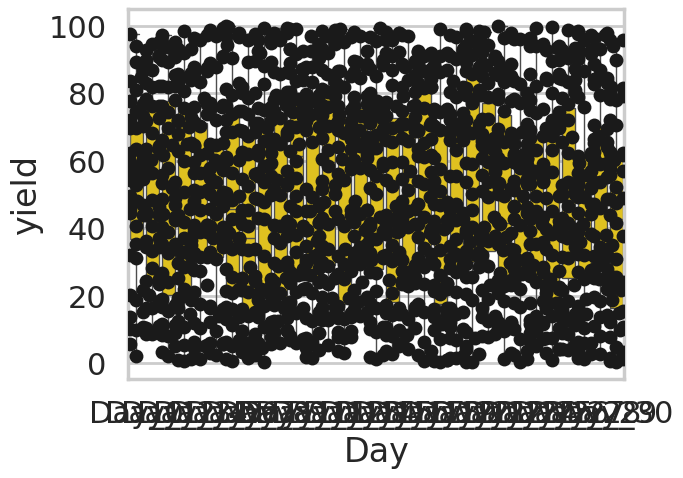

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("whitegrid")  # ✅ 正确方式


display_std = False # if you have included "yield_std" column in Results.csv will show it else disply 0 for std
day = day_finder('Results')
start_day = (1, 0)[os.path.isfile('Results_0.csv')]

Results_m = pd.DataFrame(columns=['yield', 'std', 'Day'])
for i in range(start_day, day):
    Results_i = pd.DataFrame(columns=['yield', 'std', 'Day'])
    if start_day:
        Results_i['yield'] = pd.read_csv(f'Results_{i}.csv')['yield'].iloc[0:days_range[i-1]]
    else:
        Results_i['yield'] = pd.read_csv(f'Results_{i}.csv')['yield'].iloc[0:len(pd.read_csv('Results_0.csv'))]

    try:
        if start_day:
            Results_i['std'] = pd.read_csv(f'Results_{i}.csv')['yield_std'].iloc[0:days_range[i-1]]
        else:
            Results_i['std'] = pd.read_csv(f'Results_{i}.csv')['yield_std'].iloc[0:len(pd.read_csv('Results_0.csv'))]

    except:
        Results_i['std'] = 0
    Results_i['Day'] = f'Day_{i}'
    Results_m = pd.concat([Results_m, Results_i])

import seaborn as sns
sns.set_style("whitegrid")  # ✅ 正确方式

import seaborn as sns
sns.set_theme(style="whitegrid", context="poster")  # ✅ 推荐做法

fig, ax = plt.subplots(1, 1)

ax = sns.boxplot(x='Day', y='yield', data=Results_m, color='gold', fliersize=0)
ax = sns.swarmplot(x='Day', y='yield', data=Results_m, color='k', size=10)

if display_std:
    # Find the x,y coordinates for each point
    x_coords = []
    y_coords = []
    for point_pair in ax.collections:
        for x, y in point_pair.get_offsets():
            x_coords.append(x)
            y_coords.append(y)

    errors = Results_m['std']
    ax.errorbar(x_coords, y_coords, yerr=errors, fmt=' ',color="grey", zorder=3, linewidth=1.2)
    print(errors, x_coords, y_coords)

ax

In [40]:
fig.savefig(f'Day_{day-1}_Boxplot.png', format='png', dpi=1200)
fig.savefig(f'Day_{day-1}_Boxplot.svg', format='svg', dpi=1200)

# Visualising Results For Each Metabolite

<p1><h2> When to use this part:</h2>
* you have at least one Results.csv file
<p1><h2> How to use this part:</h2>
* just run all cells!
* you can change some graphing parameter

<ipython-input-41-3904846930>:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
<ipython-input-41-3904846930>:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)


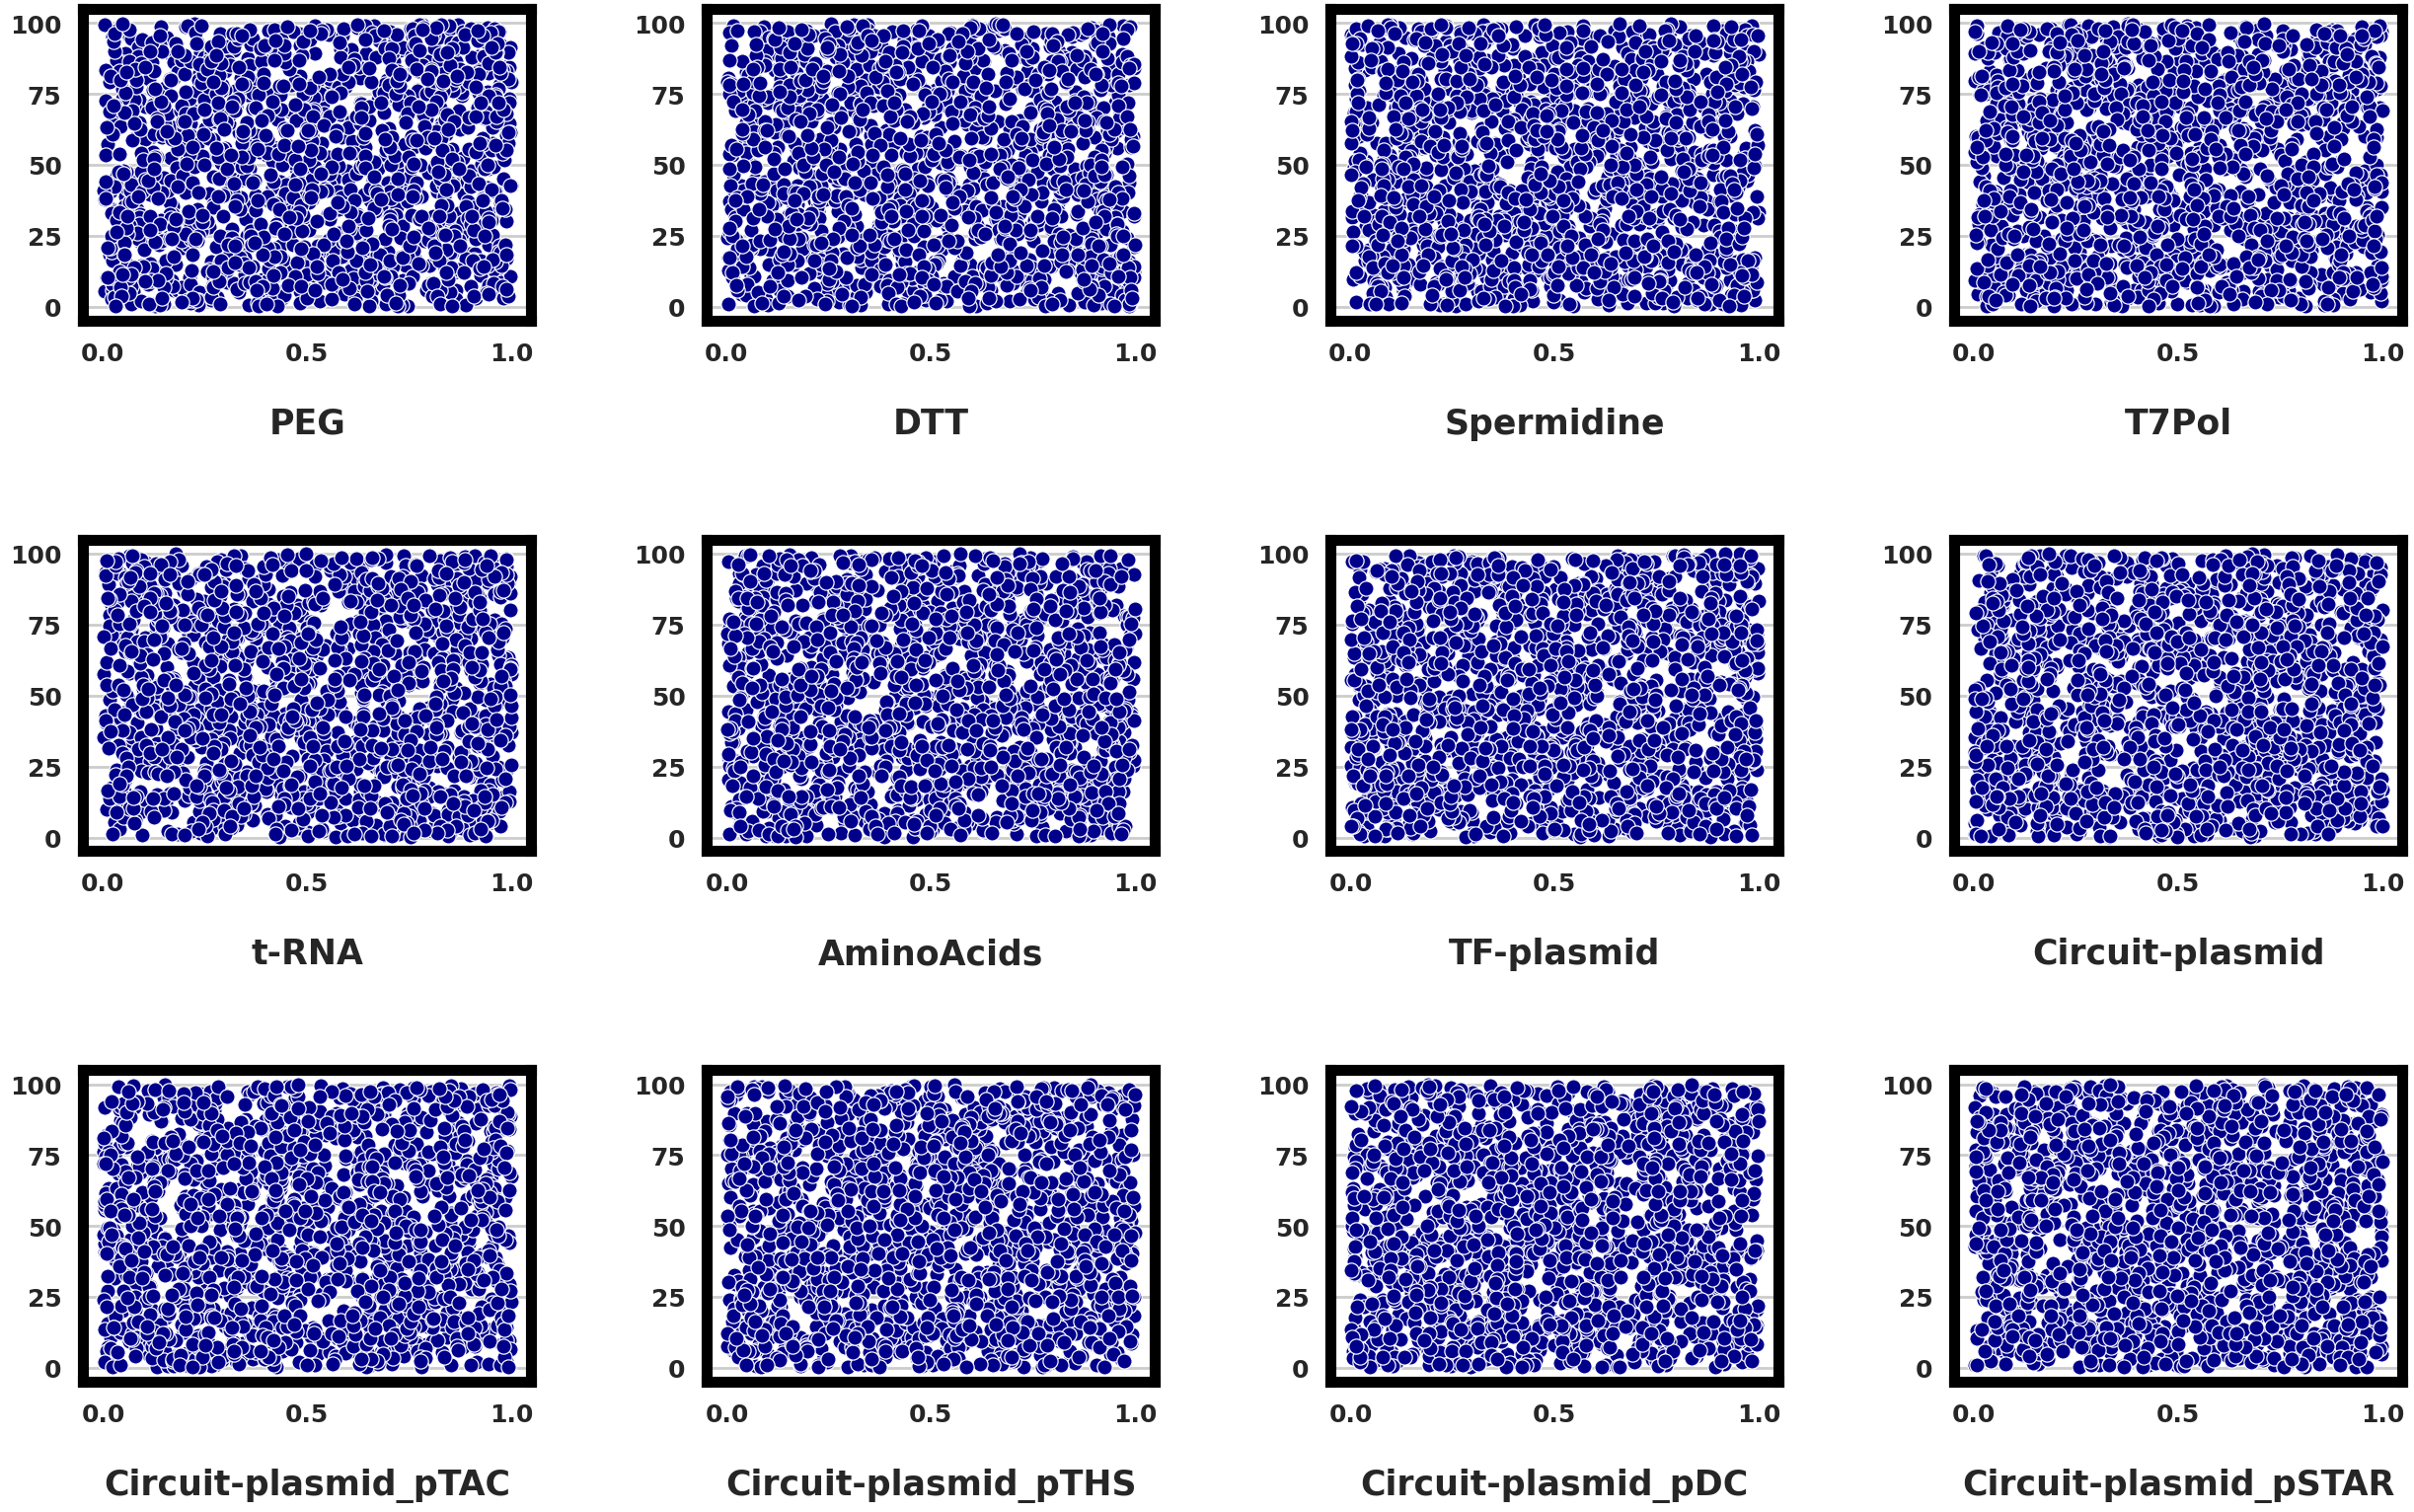

In [41]:
desired_cols = []
day = day_finder('Results')
start_day = (1, 0)[os.path.isfile('Results_0.csv')]

for key, value in concentrations_limits.items():
    if value['Alternatives']:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name
    else:
        desired_cols.append(key)

final_order = desired_cols

aggregated_data_m = pd.DataFrame(columns=desired_cols)
aggregated_label_m = pd.DataFrame(columns=['yield'])

for num in range(start_day, day):
    if start_day:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, days_range[num-1])
    else:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, len(pd.read_csv('Results_0.csv')))

    aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)

import seaborn as sns
sns.set_style("whitegrid")

num = len(desired_cols)
dim = math.ceil(math.sqrt(num))
data = pd.concat([aggregated_data_m, aggregated_label_m], axis=1)

import matplotlib as mpl


mpl.rcParams['axes.linewidth'] = 8.0 #set the value globally
mpl.rcParams['axes.edgecolor'] = 'black' #set the value globally

fig = plt.figure(figsize=(25,20))

for i in range(1, num+1):
    ax = plt.subplot(dim, dim, i)
    ax.xaxis.grid(False)
    ax = sns.scatterplot(x = desired_cols[i-1], y='yield', color='darkblue', data=data, s=120)
    y_axis = ax.axes.get_yaxis()
    y_axis.set_label_text('foo')
    y_label = y_axis.get_label()
    ##print isinstance(x_label, matplotlib.artist.Artist)
    y_label.set_visible(False)
    #ax.xaxis.set_tick_params()
    plt.xticks(weight = 'bold', fontsize=18)
    plt.yticks(weight = 'bold', fontsize=18)

    plt.xlabel(desired_cols[i-1], labelpad=30 ,fontsize=25, weight='bold')


fig.tight_layout(h_pad=3, w_pad=3)

In [42]:
fig.savefig(f'Day_{day-1}_Metabolite_Yield.png', format='png', dpi=1200)
fig.savefig(f'Day_{day-1}_Metabolite_Yield.svg', format='svg', dpi=1200)

# Viualising Concentrations From Day_1 to Now

<p1><h2> When to use this part:</h2>
* you have at least one Results.csv file
<p1><h2> How to use this part:</h2>
* just run all cells!
* you can change some graphing parameter

<ipython-input-43-3629653032>:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_all = pd.concat([data_all, data]).reset_index(drop=True)


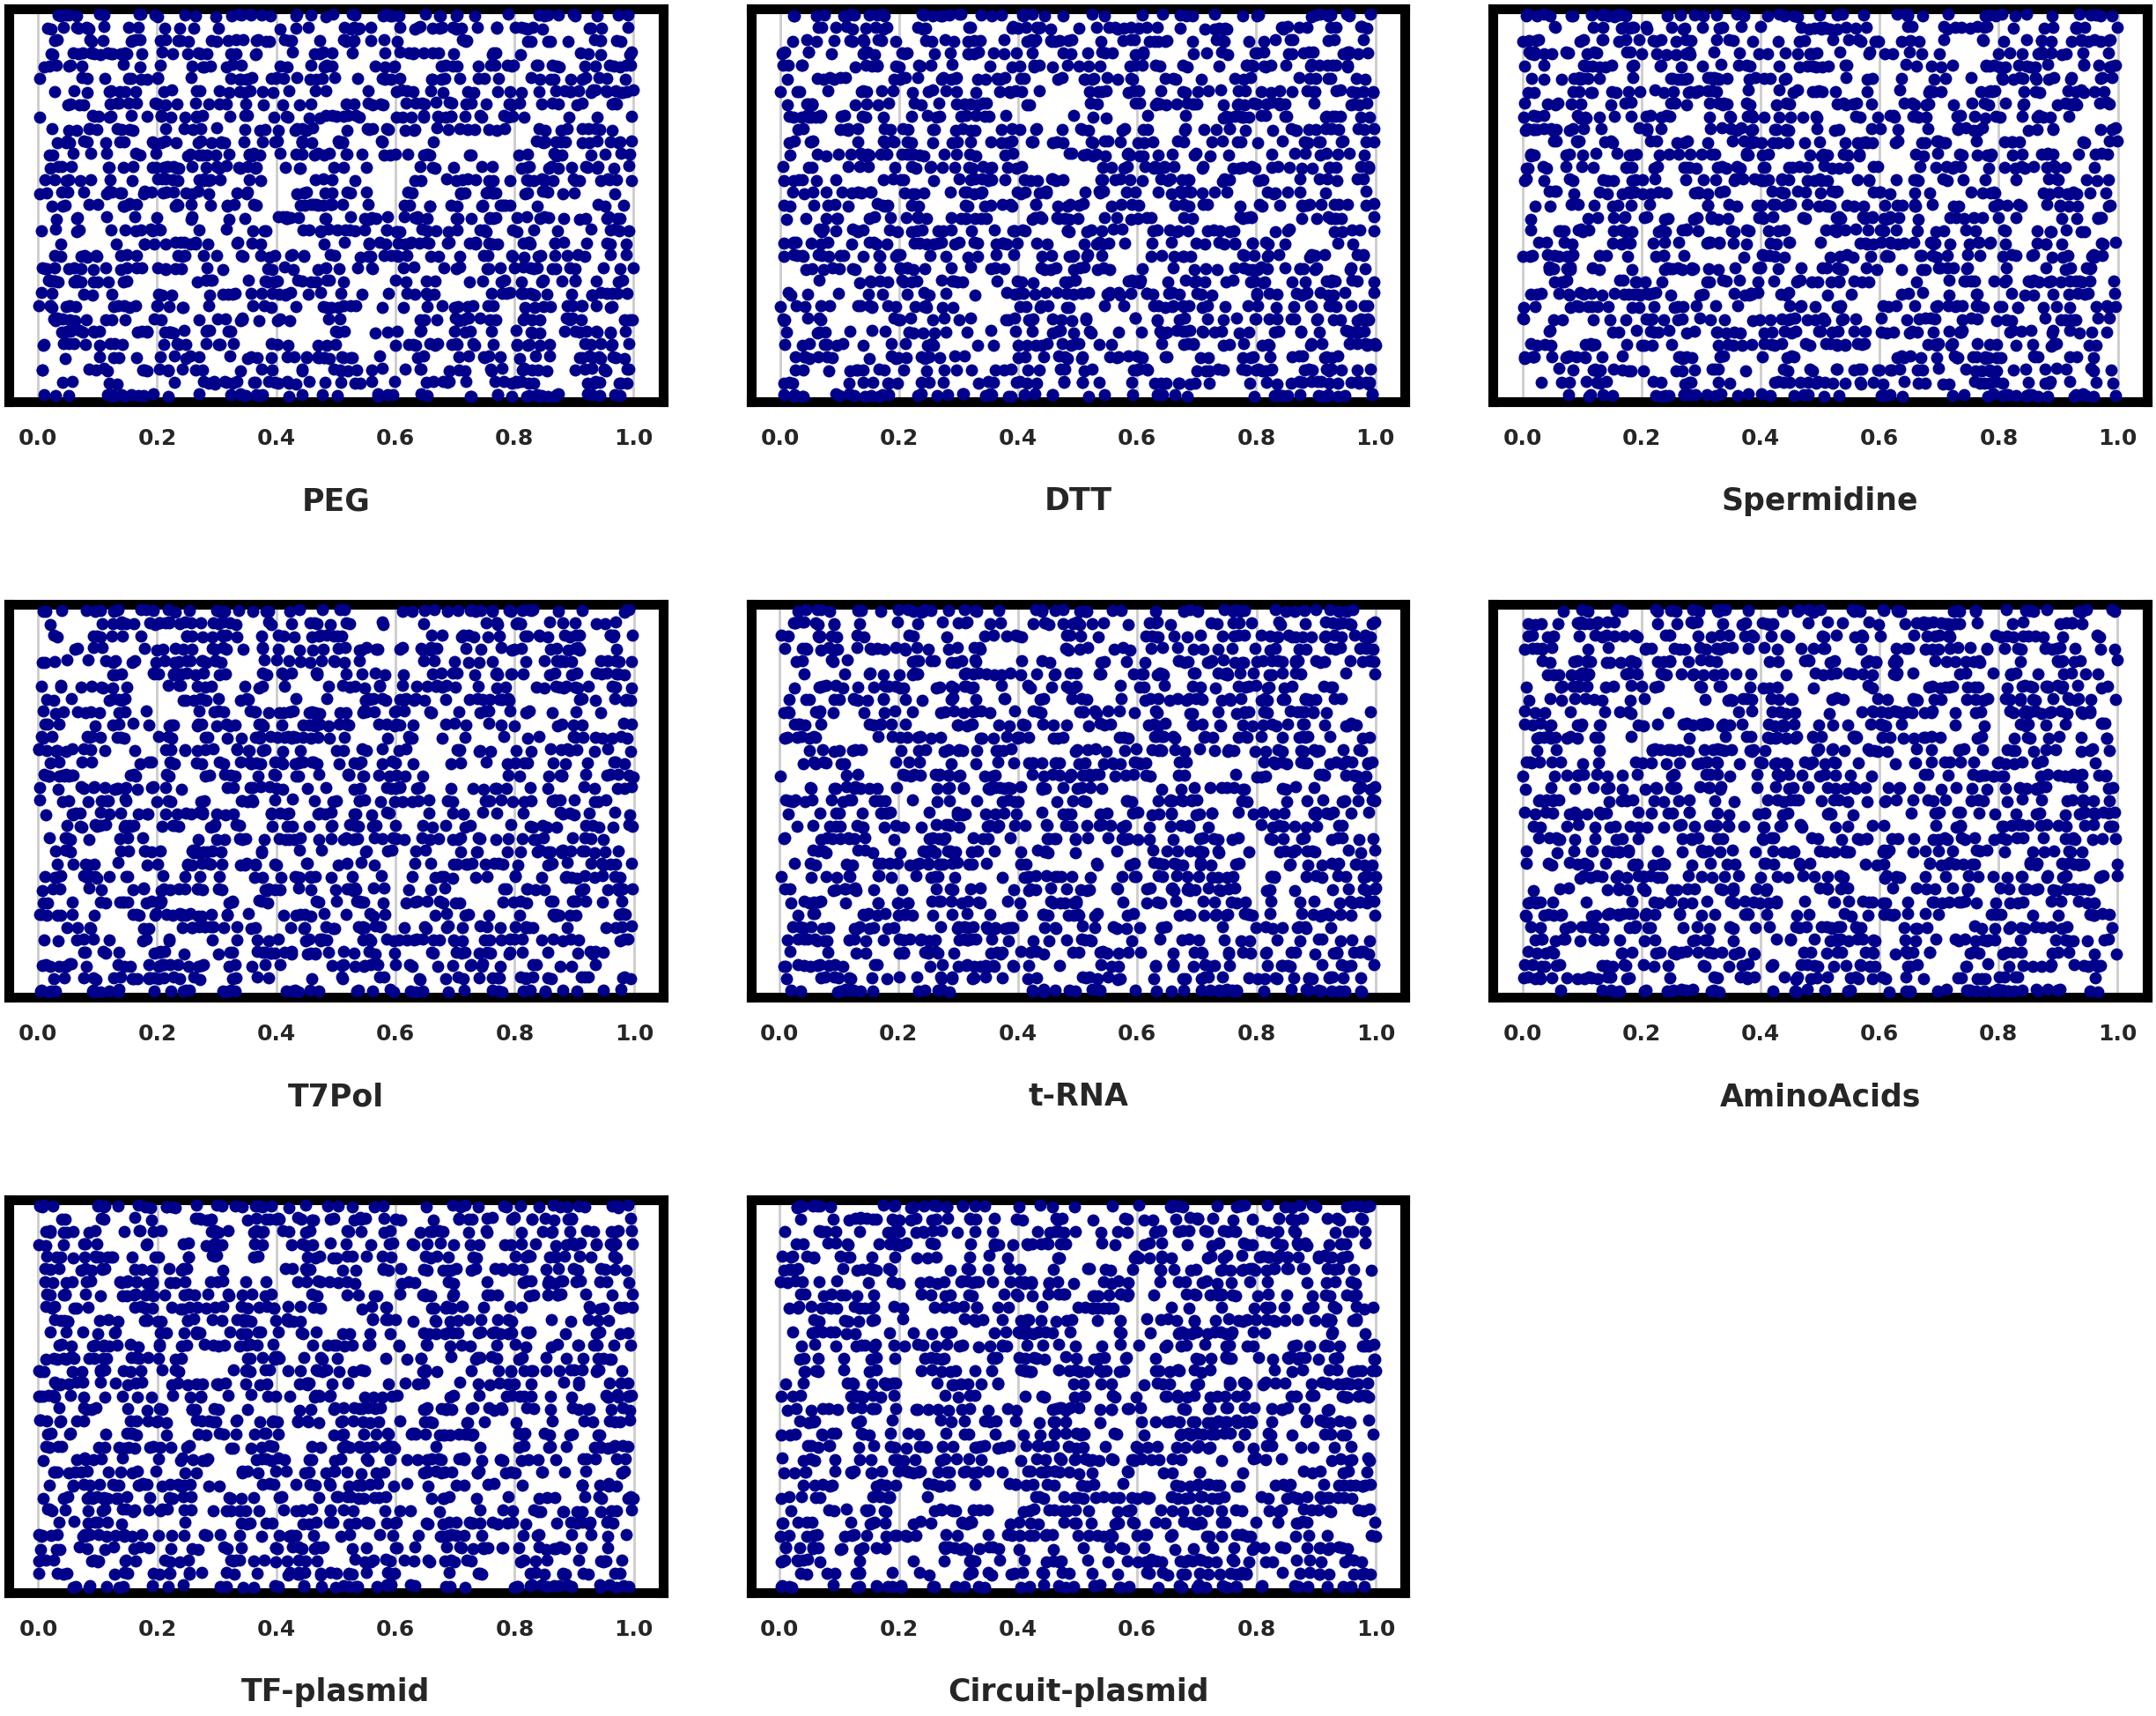

In [43]:
data_all = pd.DataFrame(columns = list(concentrations_limits.keys())+['day'])
day = day_finder('Results')
desired_cols = []

for key, value in concentrations_limits.items():
    if value['Alternatives']:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name
    else:
        desired_cols.append(key)

final_order = desired_cols

d = (1, 0)[os.path.isfile('Results_0.csv')]
days_range = []

for day in range(num_days):
    df = pd.read_csv(f"Results_{day}.csv")
    days_range.append(len(df))



while os.path.exists(f'Results_{d}.csv'):
    data = pd.read_csv(f'Results_{d}.csv')
    data = data[[*list(concentrations_limits.keys())]]
    data = data.iloc[:days_range[d-1],:]
    data['day'] = f'Day_{d}'
    data_all = pd.concat([data_all, data]).reset_index(drop=True)
    d += 1

import matplotlib as mpl


mpl.rcParams['axes.linewidth'] = 8.0 #set the value globally
mpl.rcParams['axes.edgecolor'] = 'black' #set the value globally
mpl.rcParams['xtick.major.pad'] = 10.0 #set the value globally


num = len(concentrations_limits)
dim = math.ceil(math.sqrt(num))

fig = plt.figure(figsize=(25,20))
for i in range(1, num+1):
    ax = plt.subplot(dim, dim, i)
    ax = sns.stripplot(x=list(concentrations_limits.keys())[i-1], y="day", color='darkblue', data=data_all, s=10)
    y_axis = ax.axes.get_yaxis()
    y_axis.set_label_text('foo')
    y_label = y_axis.get_label()
    y_label.set_visible(False)

    ax.yaxis.set_ticklabels([])
    plt.xticks(weight = 'bold', fontsize=18)

    plt.xlabel(desired_cols[i-1], labelpad=30 ,fontsize=25, weight='bold')


fig.tight_layout(h_pad=3, w_pad=3)

In [44]:
fig.savefig(f'Day_{day-1}_Metabolite_Days.png', format='png', dpi=1200)
fig.savefig(f'Day_{day-1}_Metabolite_Days.svg', format='svg', dpi=1200)

# Transform Volumes.csv to Table2Speech Compatible Input

<p1><h2> When to use this part:</h2>
* you have at least one Volumes_n.csv file located in Day_n Folder
<p1><h2> How to use this part:</h2>
* specify in "which_day" your Volumes file is located
* run all other cells!
* you can download Table2Speech_Volumes_n.csv file from Files

In [45]:
which_day = 1 # i.e. Volumes_1.csv is in Day_1 Folder

In [46]:
data = pd.read_csv(f'Day_{which_day}/Volumes_{which_day}.csv')

final_columns = []
columns_name = data.columns
for column in columns_name:
    if "_" in column:
        column_value = column.split('_')[0]
        column_to_add = data[column].unique()
        df_to_add = pd.DataFrame(columns = column_to_add,  data=np.zeros((len(data),len(column_to_add))))
        for i in range(len(data)):
            df_to_add[data[column].iloc[i,]][i] = data[column_value].iloc[i,]
        data = pd.concat([data, df_to_add], axis=1)
        final_columns.remove(column_value)
        final_columns += list(column_to_add)
    else:
        final_columns.append(column)

data = data[final_columns]
data

<ipython-input-46-2431532947>:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_to_add[data[column].iloc[i,]][i] = data[column_value].iloc[i,]


,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,pTAC,pSTAR,pTHS,pDC,Lysate,EnergyBuffer,IPTG-Water,water
0,2000.0,600.0,1000.0,1000.0,100.0,2500.0,200.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,1800.0
1,1800.0,800.0,300.0,400.0,100.0,2500.0,100.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,3200.0
2,2000.0,500.0,700.0,1300.0,100.0,2500.0,50.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,2050.0
3,400.0,0.0,800.0,1800.0,100.0,2500.0,400.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,3200.0
4,2000.0,500.0,800.0,1600.0,100.0,2500.0,100.0,0.0,0.0,0.0,200.0,6600.0,3500.0,500.0,1600.0
5,1200.0,0.0,400.0,400.0,100.0,2500.0,100.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,4500.0
6,400.0,100.0,700.0,400.0,100.0,2500.0,200.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,4800.0
7,1800.0,400.0,700.0,1800.0,100.0,2500.0,600.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,1300.0
8,2000.0,700.0,300.0,400.0,100.0,2500.0,600.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,2600.0
9,600.0,700.0,300.0,1300.0,100.0,2500.0,200.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,3500.0


In [47]:
data.to_csv(f'Table2Speech_Volumes_{which_day}.csv', index=False)

# Transform Volumes.csv to ECHO liquid Handler Compatible Input

<p1><h2> When to use this part:</h2>
* you have at least one Volumes_n.csv file located in Day_n Folder
<p1><h2> How to use this part:</h2>
* specify in "which_day" your Volumes file is located
* run all other cells!
* you can download Echo_Input_n.csv file from Files

In [48]:
which_day = 1 # i.e. Volumes_1.csv is in Day_1 Folder
plate_384_well = True
triplicate = False

In [49]:
data = pd.read_csv(f'Day_{which_day}/Volumes_{which_day}.csv')

final_columns = []
columns_name = data.columns
for column in columns_name:
    if "_" in column:
        column_value = column.split('_')[0]
        column_to_add = data[column].unique()
        df_to_add = pd.DataFrame(columns = column_to_add,  data=np.zeros((len(data),len(column_to_add))))
        for i in range(len(data)):
            df_to_add[data[column].iloc[i,]][i] = data[column_value].iloc[i,]
        data = pd.concat([data, df_to_add], axis=1)
        final_columns.remove(column_value)
        final_columns += list(column_to_add)
    else:
        final_columns.append(column)

data = data[final_columns]
data

<ipython-input-49-2431532947>:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_to_add[data[column].iloc[i,]][i] = data[column_value].iloc[i,]


,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,pTAC,pSTAR,pTHS,pDC,Lysate,EnergyBuffer,IPTG-Water,water
0,2000.0,600.0,1000.0,1000.0,100.0,2500.0,200.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,1800.0
1,1800.0,800.0,300.0,400.0,100.0,2500.0,100.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,3200.0
2,2000.0,500.0,700.0,1300.0,100.0,2500.0,50.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,2050.0
3,400.0,0.0,800.0,1800.0,100.0,2500.0,400.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,3200.0
4,2000.0,500.0,800.0,1600.0,100.0,2500.0,100.0,0.0,0.0,0.0,200.0,6600.0,3500.0,500.0,1600.0
5,1200.0,0.0,400.0,400.0,100.0,2500.0,100.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,4500.0
6,400.0,100.0,700.0,400.0,100.0,2500.0,200.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,4800.0
7,1800.0,400.0,700.0,1800.0,100.0,2500.0,600.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,1300.0
8,2000.0,700.0,300.0,400.0,100.0,2500.0,600.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,2600.0
9,600.0,700.0,300.0,1300.0,100.0,2500.0,200.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,3500.0


In [50]:
intermediate = put_volumes_to_384_wells(data, starting_well='A1', vertical=False, make_csv=False)
intermediate[1]

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,pTAC,pSTAR,pTHS,pDC,Lysate,EnergyBuffer,IPTG-Water,water,well_name
0,2000.0,600.0,1000.0,1000.0,100.0,2500.0,200.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,1800.0,A1
1,1800.0,800.0,300.0,400.0,100.0,2500.0,100.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,3200.0,A2
2,2000.0,500.0,700.0,1300.0,100.0,2500.0,50.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,2050.0,A3
3,400.0,0.0,800.0,1800.0,100.0,2500.0,400.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,3200.0,A4
4,2000.0,500.0,800.0,1600.0,100.0,2500.0,100.0,0.0,0.0,0.0,200.0,6600.0,3500.0,500.0,1600.0,A5
5,1200.0,0.0,400.0,400.0,100.0,2500.0,100.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,4500.0,A6
6,400.0,100.0,700.0,400.0,100.0,2500.0,200.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,4800.0,A7
7,1800.0,400.0,700.0,1800.0,100.0,2500.0,600.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,1300.0,A8
8,2000.0,700.0,300.0,400.0,100.0,2500.0,600.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,2600.0,A9
9,600.0,700.0,300.0,1300.0,100.0,2500.0,200.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,3500.0,A10


In [51]:
intermediate[0]['pTHS']

,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
A,0.0,0.0,0.0,200.0,0.0,0.0,200.0,0.0,200.0,0.0,...,0.0,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0
B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
echo_input = source_to_destination(intermediate[1], desired_order=None, reset_index=True, check_zero=False)
echo_input[1]

,Source_Plate_Barcode,Source_Well,Destination_Plate_Barcode,Destination_Well,Transfer_Volume
0,Plate1,PEG well,destPlate1,A1,2000.0
1,Plate1,PEG well,destPlate1,A2,1800.0
2,Plate1,PEG well,destPlate1,A3,2000.0
3,Plate1,PEG well,destPlate1,A4,400.0
4,Plate1,PEG well,destPlate1,A5,2000.0
...,...,...,...,...,...
295,Plate1,water well,destPlate1,A16,2600.0
296,Plate1,water well,destPlate1,A17,2450.0
297,Plate1,water well,destPlate1,A18,2550.0
298,Plate1,water well,destPlate1,A19,2500.0


In [53]:
echo_input[1].to_csv(f'Echo_Input_{which_day}.csv', index=False)

In [54]:
echo_input[0]['PEG']

,Source_Plate_Barcode,Source_Well,Destination_Plate_Barcode,Destination_Well,Transfer_Volume
0,Plate1,PEG well,destPlate1,A1,2000.0
1,Plate1,PEG well,destPlate1,A2,1800.0
2,Plate1,PEG well,destPlate1,A3,2000.0
3,Plate1,PEG well,destPlate1,A4,400.0
4,Plate1,PEG well,destPlate1,A5,2000.0
5,Plate1,PEG well,destPlate1,A6,1200.0
6,Plate1,PEG well,destPlate1,A7,400.0
7,Plate1,PEG well,destPlate1,A8,1800.0
8,Plate1,PEG well,destPlate1,A9,2000.0
9,Plate1,PEG well,destPlate1,A10,600.0


# Find K Most Informative Combinations

<p1><h2> When to use this part:</h2>
* you have at least one Results.csv file </p1>
<p1><h2> How to use this part:</h2>
* specify in "k" i.e. how many Combinations you want to get
* run all other cells!
* you can download K_Most_Informative_Combinations.csv file from Files that contain index of most informative combinations for 5 iterations</p1>

In [55]:
k = 20
number_try = 2000

In [56]:
day = day_finder('Results') - 1
start_day = (1, 0)[os.path.isfile('Results_0.csv')]

desired_cols = []
for key, value in concentrations_limits.items():
    if value['Alternatives']:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name
    else:
        desired_cols.append(key)

final_order = desired_cols

aggregated_data_m = pd.DataFrame(columns=desired_cols)
aggregated_label_m = pd.DataFrame(columns=['yield'])

for num in range(start_day, day + 1):
    if start_day or num>0:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, days_range[num-1])
    else:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, len(pd.read_csv('Results_0.csv')))

    aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)


aggregated_data_m

<ipython-input-56-3947234552>:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
<ipython-input-56-3947234552>:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)


,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,Circuit-plasmid,Circuit-plasmid_pTAC,Circuit-plasmid_pTHS,Circuit-plasmid_pDC,Circuit-plasmid_pSTAR
0,0.037440,0.408830,0.133413,0.230017,0.513704,0.934009,0.527702,0.032803,0.996047,0.728378,0.189482,0.486546
1,0.733101,0.269378,0.970482,0.313128,0.773059,0.607203,0.188197,0.037890,0.693181,0.786995,0.678935,0.794561
2,0.850163,0.607995,0.154450,0.218867,0.131878,0.295910,0.025110,0.951335,0.111287,0.847398,0.891356,0.589170
3,0.528314,0.406506,0.672378,0.873436,0.831275,0.328748,0.448345,0.495218,0.535240,0.856387,0.721618,0.752053
4,0.676318,0.922553,0.715611,0.382492,0.558306,0.557266,0.840989,0.191383,0.628201,0.430007,0.597704,0.460116
...,...,...,...,...,...,...,...,...,...,...,...,...
1545,0.978052,0.307233,0.946055,0.633716,0.243104,0.064656,0.592502,0.467399,0.894513,0.327075,0.944267,0.257268
1546,0.051325,0.663665,0.846253,0.104998,0.461812,0.839886,0.343631,0.528808,0.611902,0.933378,0.645113,0.258867
1547,0.968329,0.852380,0.135139,0.596685,0.766466,0.252839,0.586110,0.864687,0.319402,0.360290,0.443967,0.354877
1548,0.794998,0.836596,0.290884,0.826456,0.813030,0.751776,0.983132,0.714847,0.886891,0.009045,0.441406,0.331577


In [57]:
# Create the grid search parameter grid and scoring funcitons
param_grid = {
        "learning_rate": [0.01, 0.03, 0.1, 0.3],
        "colsample_bytree": [0.6, 0.8, 0.9, 1.0],
        "subsample": [0.6, 0.8, 0.9, 1.0],
        "max_depth": [2, 3, 4, 6 , 8],
        "n_estimators": [10, 20,  40, 60, 80, 100, 300, 500],
        "reg_lambda": [1, 1.5, 2],
        "gamma": [0, 0.1, 0.4, 0.6],
        "min_child_weight": [1, 2, 4]}

# create the grid search object
grid = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        cv=5,
        scoring= 'neg_mean_absolute_error',
        n_jobs=-1,
        n_iter=n_iter)

print('RandomSearchCV ...')
grid.fit(aggregated_data_m.values, aggregated_label_m.values)
results = pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)
print('RandomSearchCV Done!')

RandomSearchCV ...
RandomSearchCV Done!


In [58]:
indexs = []
num = 0
while num < number_try:
    numbers = set()
    while len(numbers) < k:
        numbers.add(random.randint(0, len(aggregated_data_m)-1))
    indexs.append(numbers)
    num += 1

In [59]:
performance = []
best_param = results.params.iloc[0,]
all_set = set(range(len(aggregated_data_m)))
counter = 0
for index in indexs:
    counter += 1
    if counter%100 == 0:print(counter)
    index_test = all_set - index
    index_test = list(index_test)
    index = list(index)
    model = XGBRegressor(objective = 'reg:squarederror', **best_param)
    model.fit(aggregated_data_m.iloc[index].values, aggregated_label_m.iloc[index].values)
    performance.append(spearmanr(model.predict(aggregated_data_m.iloc[index_test].values), aggregated_label_m.iloc[index_test].values).correlation**2)

performance = np.array(performance)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


In [60]:
number_to_select = 5
ind = np.argpartition(performance, -number_to_select)[-number_to_select:]
performance[ind]

array([0.0064468 , 0.00701953, 0.00717739, 0.00740909, 0.00743142])

In [61]:
np.array(indexs)[ind]

array([{272, 19, 20, 790, 407, 919, 673, 679, 425, 46, 695, 1483, 1487, 591, 1362, 1371, 1385, 1142, 247, 1401},
       {1153, 5, 646, 263, 1169, 1049, 1444, 39, 1449, 1451, 1332, 182, 1485, 1103, 861, 614, 1523, 499, 502, 1273},
       {1422, 1042, 914, 1435, 926, 170, 433, 692, 693, 1465, 1212, 454, 201, 715, 82, 1379, 745, 1259, 1529, 255},
       {1288, 781, 1295, 1045, 1179, 289, 417, 675, 47, 950, 1211, 956, 1215, 1219, 1222, 86, 478, 620, 1262, 114},
       {898, 899, 1415, 270, 20, 161, 436, 1078, 958, 455, 714, 982, 1240, 986, 1509, 616, 362, 626, 246, 765}],
      dtype=object)

In [62]:
pd.DataFrame(np.array(indexs)[ind]).to_csv('K_Most_Informative_Combinations.csv', index=False)

# Find Feature Importances


<p1><h2> When to use this part:</h2>
* you have at least one Results.csv file </p1>
<p1><h2> How to use this part:</h2>
* run all cells!
* you can download importance_df.csv  from Files</p1>

In [63]:
n_iter = 200

In [64]:
day = day_finder('Results') - 1
start_day = (1, 0)[os.path.isfile('Results_0.csv')]

desired_cols = []
for key, value in concentrations_limits.items():
    if value['Alternatives']:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name
    else:
        desired_cols.append(key)

final_order = desired_cols

In [65]:
import os
print(sorted(os.listdir()))



['.config', 'Day_1', 'Day_29_Metabolite_Days.png', 'Day_29_Metabolite_Days.svg', 'Day_30_Boxplot.png', 'Day_30_Boxplot.svg', 'Day_30_Metabolite_Yield.png', 'Day_30_Metabolite_Yield.svg', 'Day_31', 'Echo_Input_1.csv', 'Functions_Final_v3_1.py', 'K_Most_Informative_Combinations.csv', 'Results_0.csv', 'Results_1.csv', 'Results_10.csv', 'Results_11.csv', 'Results_12.csv', 'Results_13.csv', 'Results_14.csv', 'Results_15.csv', 'Results_16.csv', 'Results_17.csv', 'Results_18.csv', 'Results_19.csv', 'Results_2.csv', 'Results_20.csv', 'Results_21.csv', 'Results_22.csv', 'Results_23.csv', 'Results_24.csv', 'Results_25.csv', 'Results_26.csv', 'Results_27.csv', 'Results_28.csv', 'Results_29.csv', 'Results_3.csv', 'Results_30.csv', 'Results_4.csv', 'Results_5.csv', 'Results_6.csv', 'Results_7.csv', 'Results_8.csv', 'Results_9.csv', 'Table2Speech_Volumes_1.csv', '__pycache__', 'sample_data', 'simulated_results']


In [66]:
!pip install xgboost
from xgboost import XGBRegressor
!pip install scikit-learn
from sklearn.model_selection import RandomizedSearchCV
importance_list = []
print('This may takes minutes!')
n_iter = 10  # 你可以根据需要调整为其他整数
start_day = 1
day = 30
desired_cols = [
    'PEG', 'DTT', 'Spermidine', 'T7Pol', 't-RNA', 'AminoAcids',
    'TF-plasmid', 'Circuit-plasmid', 'Circuit-plasmid_pTAC',
    'Circuit-plasmid_pTHS', 'Circuit-plasmid_pDC', 'Circuit-plasmid_pSTAR'
]
days_range = [50] * 31  # 每一天固定50条记录（与生成数据一致）

def result_preprocess(day, desired_cols, n_samples):
    df = pd.read_csv(f"Results_{day}.csv")  # ❌ 不要加 simulated_results/
    df = df.iloc[:n_samples]
    data = df[desired_cols].copy()
    label = df[['yield']].copy()
    return data, label, None, None


for day_i in range(1, day + 1):
    aggregated_data_m = pd.DataFrame(columns=desired_cols)
    aggregated_label_m = pd.DataFrame(columns=['yield'])

    for num in range(start_day, day_i + 1):
        data_m, label_m, _, _ = result_preprocess(num, desired_cols, days_range[num - 1])
        aggregated_data_m = pd.concat([aggregated_data_m, data_m], ignore_index=True)
        aggregated_label_m = pd.concat([aggregated_label_m, label_m], ignore_index=True)


    # Create the grid search parameter grid and scoring funcitons
    param_grid = {
        "learning_rate": [0.01, 0.03, 0.1, 0.3],
        "colsample_bytree": [0.6, 0.8, 0.9, 1.0],
        "subsample": [0.6, 0.8, 0.9, 1.0],
        "max_depth": [2, 3, 4, 6 , 8],
        "n_estimators": [10, 20,  40, 60, 80, 100, 300, 500],
        "reg_lambda": [1, 1.5, 2],
        "gamma": [0, 0.1, 0.4, 0.6],
        "min_child_weight": [1, 2, 4]}

    # creat estimator
    model = XGBRegressor(objective = 'reg:squarederror')

    # create the grid search object
    grid = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        cv=5,
        scoring= 'neg_mean_absolute_error',
        n_jobs=-1,
        n_iter=n_iter)

    print('RandomSearchCV ...', day_i)
    grid.fit(aggregated_data_m.values, aggregated_label_m.values)
    results = pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)
    print('RandomSearchCV Done!')

    model = XGBRegressor(objective = 'reg:squarederror', **results.params.iloc[0,])
    model.fit(aggregated_data_m.values, aggregated_label_m.values)
    importance_list.append(model.feature_importances_)

This may takes minutes!
RandomSearchCV ... 1


<ipython-input-66-2604164497>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_data_m = pd.concat([aggregated_data_m, data_m], ignore_index=True)
<ipython-input-66-2604164497>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_label_m = pd.concat([aggregated_label_m, label_m], ignore_index=True)


RandomSearchCV Done!
RandomSearchCV ... 2


<ipython-input-66-2604164497>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_data_m = pd.concat([aggregated_data_m, data_m], ignore_index=True)
<ipython-input-66-2604164497>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_label_m = pd.concat([aggregated_label_m, label_m], ignore_index=True)


RandomSearchCV Done!
RandomSearchCV ... 3


<ipython-input-66-2604164497>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_data_m = pd.concat([aggregated_data_m, data_m], ignore_index=True)
<ipython-input-66-2604164497>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_label_m = pd.concat([aggregated_label_m, label_m], ignore_index=True)


RandomSearchCV Done!
RandomSearchCV ... 4


<ipython-input-66-2604164497>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_data_m = pd.concat([aggregated_data_m, data_m], ignore_index=True)
<ipython-input-66-2604164497>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_label_m = pd.concat([aggregated_label_m, label_m], ignore_index=True)


RandomSearchCV Done!
RandomSearchCV ... 5


<ipython-input-66-2604164497>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_data_m = pd.concat([aggregated_data_m, data_m], ignore_index=True)
<ipython-input-66-2604164497>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_label_m = pd.concat([aggregated_label_m, label_m], ignore_index=True)


RandomSearchCV Done!
RandomSearchCV ... 6


<ipython-input-66-2604164497>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_data_m = pd.concat([aggregated_data_m, data_m], ignore_index=True)
<ipython-input-66-2604164497>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_label_m = pd.concat([aggregated_label_m, label_m], ignore_index=True)


RandomSearchCV Done!
RandomSearchCV ... 7


<ipython-input-66-2604164497>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_data_m = pd.concat([aggregated_data_m, data_m], ignore_index=True)
<ipython-input-66-2604164497>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_label_m = pd.concat([aggregated_label_m, label_m], ignore_index=True)


RandomSearchCV Done!


<ipython-input-66-2604164497>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_data_m = pd.concat([aggregated_data_m, data_m], ignore_index=True)
<ipython-input-66-2604164497>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_label_m = pd.concat([aggregated_label_m, label_m], ignore_index=True)


RandomSearchCV ... 8
RandomSearchCV Done!
RandomSearchCV ... 9


<ipython-input-66-2604164497>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_data_m = pd.concat([aggregated_data_m, data_m], ignore_index=True)
<ipython-input-66-2604164497>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_label_m = pd.concat([aggregated_label_m, label_m], ignore_index=True)


RandomSearchCV Done!


<ipython-input-66-2604164497>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_data_m = pd.concat([aggregated_data_m, data_m], ignore_index=True)
<ipython-input-66-2604164497>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_label_m = pd.concat([aggregated_label_m, label_m], ignore_index=True)


RandomSearchCV ... 10
RandomSearchCV Done!
RandomSearchCV ... 11


<ipython-input-66-2604164497>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_data_m = pd.concat([aggregated_data_m, data_m], ignore_index=True)
<ipython-input-66-2604164497>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_label_m = pd.concat([aggregated_label_m, label_m], ignore_index=True)


RandomSearchCV Done!
RandomSearchCV ... 12


<ipython-input-66-2604164497>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_data_m = pd.concat([aggregated_data_m, data_m], ignore_index=True)
<ipython-input-66-2604164497>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_label_m = pd.concat([aggregated_label_m, label_m], ignore_index=True)


RandomSearchCV Done!
RandomSearchCV ... 13


<ipython-input-66-2604164497>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_data_m = pd.concat([aggregated_data_m, data_m], ignore_index=True)
<ipython-input-66-2604164497>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_label_m = pd.concat([aggregated_label_m, label_m], ignore_index=True)


RandomSearchCV Done!


<ipython-input-66-2604164497>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_data_m = pd.concat([aggregated_data_m, data_m], ignore_index=True)
<ipython-input-66-2604164497>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_label_m = pd.concat([aggregated_label_m, label_m], ignore_index=True)


RandomSearchCV ... 14
RandomSearchCV Done!
RandomSearchCV ... 15


<ipython-input-66-2604164497>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_data_m = pd.concat([aggregated_data_m, data_m], ignore_index=True)
<ipython-input-66-2604164497>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_label_m = pd.concat([aggregated_label_m, label_m], ignore_index=True)


RandomSearchCV Done!
RandomSearchCV ... 16


<ipython-input-66-2604164497>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_data_m = pd.concat([aggregated_data_m, data_m], ignore_index=True)
<ipython-input-66-2604164497>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_label_m = pd.concat([aggregated_label_m, label_m], ignore_index=True)


RandomSearchCV Done!
RandomSearchCV ... 17


<ipython-input-66-2604164497>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_data_m = pd.concat([aggregated_data_m, data_m], ignore_index=True)
<ipython-input-66-2604164497>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_label_m = pd.concat([aggregated_label_m, label_m], ignore_index=True)


RandomSearchCV Done!
RandomSearchCV ... 18


<ipython-input-66-2604164497>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_data_m = pd.concat([aggregated_data_m, data_m], ignore_index=True)
<ipython-input-66-2604164497>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_label_m = pd.concat([aggregated_label_m, label_m], ignore_index=True)


RandomSearchCV Done!
RandomSearchCV ... 19


<ipython-input-66-2604164497>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_data_m = pd.concat([aggregated_data_m, data_m], ignore_index=True)
<ipython-input-66-2604164497>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_label_m = pd.concat([aggregated_label_m, label_m], ignore_index=True)


RandomSearchCV Done!
RandomSearchCV ... 20


<ipython-input-66-2604164497>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_data_m = pd.concat([aggregated_data_m, data_m], ignore_index=True)
<ipython-input-66-2604164497>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_label_m = pd.concat([aggregated_label_m, label_m], ignore_index=True)


RandomSearchCV Done!


<ipython-input-66-2604164497>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_data_m = pd.concat([aggregated_data_m, data_m], ignore_index=True)
<ipython-input-66-2604164497>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_label_m = pd.concat([aggregated_label_m, label_m], ignore_index=True)


RandomSearchCV ... 21
RandomSearchCV Done!
RandomSearchCV ... 22


<ipython-input-66-2604164497>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_data_m = pd.concat([aggregated_data_m, data_m], ignore_index=True)
<ipython-input-66-2604164497>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_label_m = pd.concat([aggregated_label_m, label_m], ignore_index=True)


RandomSearchCV Done!
RandomSearchCV ... 23


<ipython-input-66-2604164497>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_data_m = pd.concat([aggregated_data_m, data_m], ignore_index=True)
<ipython-input-66-2604164497>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_label_m = pd.concat([aggregated_label_m, label_m], ignore_index=True)


RandomSearchCV Done!
RandomSearchCV ... 24


<ipython-input-66-2604164497>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_data_m = pd.concat([aggregated_data_m, data_m], ignore_index=True)
<ipython-input-66-2604164497>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_label_m = pd.concat([aggregated_label_m, label_m], ignore_index=True)


RandomSearchCV Done!
RandomSearchCV ... 25


<ipython-input-66-2604164497>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_data_m = pd.concat([aggregated_data_m, data_m], ignore_index=True)
<ipython-input-66-2604164497>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_label_m = pd.concat([aggregated_label_m, label_m], ignore_index=True)


RandomSearchCV Done!
RandomSearchCV ... 26


<ipython-input-66-2604164497>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_data_m = pd.concat([aggregated_data_m, data_m], ignore_index=True)
<ipython-input-66-2604164497>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_label_m = pd.concat([aggregated_label_m, label_m], ignore_index=True)


RandomSearchCV Done!
RandomSearchCV ... 27


<ipython-input-66-2604164497>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_data_m = pd.concat([aggregated_data_m, data_m], ignore_index=True)
<ipython-input-66-2604164497>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_label_m = pd.concat([aggregated_label_m, label_m], ignore_index=True)


RandomSearchCV Done!
RandomSearchCV ... 28


<ipython-input-66-2604164497>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_data_m = pd.concat([aggregated_data_m, data_m], ignore_index=True)
<ipython-input-66-2604164497>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_label_m = pd.concat([aggregated_label_m, label_m], ignore_index=True)


RandomSearchCV Done!
RandomSearchCV ... 29


<ipython-input-66-2604164497>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_data_m = pd.concat([aggregated_data_m, data_m], ignore_index=True)
<ipython-input-66-2604164497>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_label_m = pd.concat([aggregated_label_m, label_m], ignore_index=True)


RandomSearchCV Done!
RandomSearchCV ... 30


<ipython-input-66-2604164497>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_data_m = pd.concat([aggregated_data_m, data_m], ignore_index=True)
<ipython-input-66-2604164497>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_label_m = pd.concat([aggregated_label_m, label_m], ignore_index=True)


RandomSearchCV Done!


In [67]:
importance_df = pd.DataFrame(importance_list, columns=aggregated_data_m.columns)
importance_df

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,Circuit-plasmid,Circuit-plasmid_pTAC,Circuit-plasmid_pTHS,Circuit-plasmid_pDC,Circuit-plasmid_pSTAR
0,0.115151,0.135509,0.106320,0.053551,0.030371,0.042322,0.051788,0.051119,0.106889,0.100370,0.114082,0.092528
1,0.017171,0.214602,0.000000,0.000000,0.137054,0.283208,0.148062,0.000000,0.184665,0.015238,0.000000,0.000000
2,0.062554,0.132720,0.048794,0.074563,0.132692,0.108122,0.087475,0.065116,0.086561,0.050537,0.080606,0.070262
3,0.060102,0.131876,0.073224,0.066808,0.084385,0.058253,0.127240,0.090474,0.064924,0.059353,0.095677,0.087684
4,0.057564,0.105150,0.074805,0.086601,0.098430,0.051162,0.095574,0.077526,0.086480,0.102186,0.091850,0.072671
5,0.060701,0.122727,0.070459,0.065423,0.098844,0.054991,0.084541,0.094219,0.097898,0.080777,0.085923,0.083497
6,0.090876,0.112720,0.092810,0.094277,0.142743,0.076667,0.000000,0.094063,0.099184,0.000000,0.095376,0.101285
7,0.109006,0.156809,0.130082,0.000000,0.107179,0.062409,0.115863,0.000000,0.133474,0.000000,0.080500,0.104679
8,0.040120,0.057669,0.067882,0.064618,0.085134,0.083620,0.101135,0.092547,0.104460,0.095451,0.105439,0.101926
9,0.087788,0.078313,0.083267,0.088227,0.080977,0.070195,0.091688,0.059574,0.100125,0.093990,0.088989,0.076867


In [68]:
importance_df.to_csv('importance_df.csv', index=False)

* find feature importance through
sklearn.feature_selection.mutual_info_regression

In [69]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler

In [70]:
scaler_x = StandardScaler()
X = scaler_x.fit_transform(aggregated_data_m.values)
scaler_y = StandardScaler()
y = scaler_y.fit_transform(aggregated_label_m.values)

In [71]:
importance_df_sklearn = pd.DataFrame(mutual_info_regression(X, y)).T
importance_df_sklearn.columns = aggregated_data_m.columns
importance_df_sklearn

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,Circuit-plasmid,Circuit-plasmid_pTAC,Circuit-plasmid_pTHS,Circuit-plasmid_pDC,Circuit-plasmid_pSTAR
0,0.0,0.043281,0.0,0.008249,0.0,0.0,0.0,0.0,0.01886,0.012284,0.0,0.0


In [72]:
importance_df_sklearn.to_csv('importance_df_sklearn.csv', index=False)


# Find NonLinear Interactions

<p1><h2> When to use this part:</h2>
* you have at least one Results.csv file </p1>
<p1><h2> How to use this part:</h2>
* run all cells!
* you can download Interactions.png from Files</p1>

In [73]:
day = day_finder('Results') - 1
start_day = (1, 0)[os.path.isfile('Results_0.csv')]

desired_cols = []
for key, value in concentrations_limits.items():
    if value['Alternatives']:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name
    else:
        desired_cols.append(key)

final_order = desired_cols

aggregated_data_m = pd.DataFrame(columns=desired_cols)
aggregated_label_m = pd.DataFrame(columns=['yield'])

for num in range(start_day, day + 1):
    if start_day or num>0:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, days_range[num-1])
    else:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, len(pd.read_csv('Results_0.csv')))

    aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)


aggregated_data_m

<ipython-input-73-3947234552>:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
<ipython-input-73-3947234552>:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)


,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,Circuit-plasmid,Circuit-plasmid_pTAC,Circuit-plasmid_pTHS,Circuit-plasmid_pDC,Circuit-plasmid_pSTAR
0,0.037440,0.408830,0.133413,0.230017,0.513704,0.934009,0.527702,0.032803,0.996047,0.728378,0.189482,0.486546
1,0.733101,0.269378,0.970482,0.313128,0.773059,0.607203,0.188197,0.037890,0.693181,0.786995,0.678935,0.794561
2,0.850163,0.607995,0.154450,0.218867,0.131878,0.295910,0.025110,0.951335,0.111287,0.847398,0.891356,0.589170
3,0.528314,0.406506,0.672378,0.873436,0.831275,0.328748,0.448345,0.495218,0.535240,0.856387,0.721618,0.752053
4,0.676318,0.922553,0.715611,0.382492,0.558306,0.557266,0.840989,0.191383,0.628201,0.430007,0.597704,0.460116
...,...,...,...,...,...,...,...,...,...,...,...,...
1545,0.978052,0.307233,0.946055,0.633716,0.243104,0.064656,0.592502,0.467399,0.894513,0.327075,0.944267,0.257268
1546,0.051325,0.663665,0.846253,0.104998,0.461812,0.839886,0.343631,0.528808,0.611902,0.933378,0.645113,0.258867
1547,0.968329,0.852380,0.135139,0.596685,0.766466,0.252839,0.586110,0.864687,0.319402,0.360290,0.443967,0.354877
1548,0.794998,0.836596,0.290884,0.826456,0.813030,0.751776,0.983132,0.714847,0.886891,0.009045,0.441406,0.331577


In [74]:
from sklearn.linear_model import LinearRegression
from itertools import combinations

model = LinearRegression()
model.fit(aggregated_data_m.values, aggregated_label_m.values)
baseline_score = pearsonr(pd.DataFrame(model.predict(aggregated_data_m.values))[0] ,aggregated_label_m['yield'])
baseline_score

PearsonRResult(statistic=np.float64(0.11447360856346454), pvalue=np.float64(6.241064728987225e-06))

In [75]:
interaction_scores = {}
for i in combinations(aggregated_data_m.columns, 2):
    X = pd.concat([aggregated_data_m, (aggregated_data_m[i[0]] * aggregated_data_m[i[1]])], axis=1)
    y = aggregated_label_m

    model = LinearRegression()
    model.fit(X.values, y.values)
    score = pearsonr(pd.DataFrame(model.predict(X.values))[0] ,y['yield'])

    interaction_scores[i] = score

In [76]:
interactions_df = pd.DataFrame(data=np.zeros([len(aggregated_data_m.columns), len(aggregated_data_m.columns)]), columns=aggregated_data_m.columns, index=aggregated_data_m.columns)

for columns, value in interaction_scores.items():
    diff = value[0] - baseline_score[0]
    interactions_df[columns[0]][columns[1]] = diff

<ipython-input-76-2760720967>:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  interactions_df[columns[0]][columns[1]] = diff


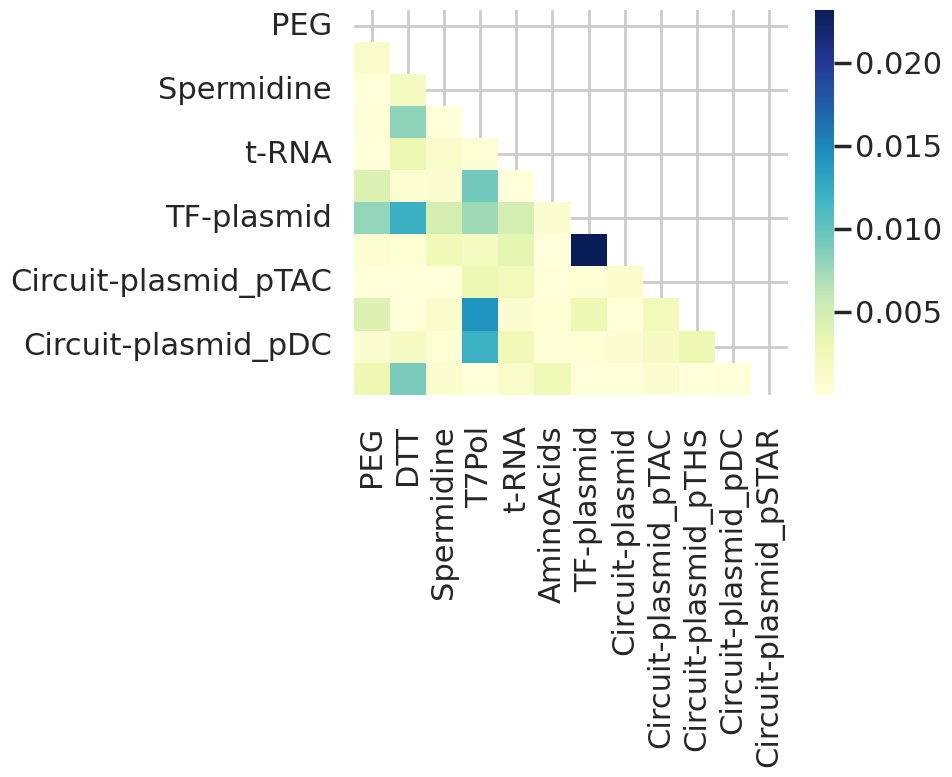

In [77]:
corr = np.corrcoef(np.random.randn(len(aggregated_data_m.columns), 200))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize = (7,5))
ax = sns.heatmap(interactions_df, mask=mask, cmap='YlGnBu')

In [78]:
fig.savefig('Interactions.png', format='png', dpi=1200)
fig.savefig('Interactions.svg', format='svg', dpi=1200)